<a href="https://colab.research.google.com/github/schmcklr/skill_extractor/blob/main/skill_extractor_analysis_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 3:** Skill Analysis

The present program offers a variety of features designed to track and analyze the progression of desired job qualifications over time. The program should be executed in Google Colab with GPU acceleration enabled. There are two implemented options for this:

1.   Static LDA Topic Modeling & Skill-Count Analysis
2.   Dynamic LDA Topic Modeling


# 1. Load data, applying filters & defining basic functions
1.1 Import of preprocessed and translated job advertisements ([part 2](https://colab.research.google.com/drive/1EvylGHg4NLHiKnsAmW9l42AQUzLT2c5w#scrollTo=K2XUY2Qk6n7w&uniqifier=2))



In [49]:
!pip install --upgrade pandas --quiet
import pandas as pd

#Fetching preprocessed data
workbook = 'https://github.com/schmcklr/skill_extractor/blob/main/job_data/job_data_preprocessed_extracted_qualifications.xlsx?raw=true'
#BETA: Final text after cleaning part1 and part2
workbook = 'https://github.com/schmcklr/skill_extractor/blob/main/job_data/job_data_preprocessed_extracted_qualifications_final.xlsx?raw=true'

# Import of tabs
job_data = pd.read_excel(workbook, sheet_name="Sheet1")

# Convert to lower case
job_data = job_data.applymap(lambda x: x.lower() if isinstance(x, str) else x)

# Number of job advertisements before filtering
number_of_job_ads_before_filtering = str(len(job_data['description']))

1.2 Define Filters for analysis

In [50]:
# Keywords for title filtering
job_keywords_title = ["bpm", "process", "bpmn", "business process management", "bpm", "bpmn", "business process analysis", "process improvement", "process analysis", "business process"]
# Keywords for description filtering
job_keywords_description = ["business process management", "bpm", "bpmn", "process improvement", "process analysis", "business process"]

# Filter #1: Filter job ads by keywords
# Option (1): Filter job titles
job_data = job_data[job_data['title'].str.contains('|'.join(job_keywords_title), case=False)]
# Option (2): Filter job description
#job_data = job_data[job_data['rawDescription'].str.contains('|'.join(job_keywords_description), case=False)]

# Filter #2: Filter for specific years (deactivated by default)
filter_for_years = False
years = [2018, 2019, 2020 ,2021, 2022]

# Filter #3: Filter out internships/working student jobs (activated by default)
student_keywords = ["internship", "working student", "intern", "practical", "praktikum"]
job_data = job_data[~job_data['title'].str.contains('|'.join(student_keywords), case=False)]

# Filter #4: Filter descripton by predefined skills (deactivated by default)
filter_by_skills = False

# User info (Number of job advertisements after filtering)
print('Filtering successfull! ' + str(len(job_data['description'])) + '/' + number_of_job_ads_before_filtering + ' Job advertisements are left.')

Filtering successfull! 196/2457 Job advertisements are left.


1.3 Preview of filtered job data




In [51]:
# Displaying job data
import pandas as pd
from IPython.display import display, HTML

# Set pandas display option
pd.set_option('display.max_colwidth', None)

job_data_display = job_data[['title', 'qualifications', 'created_at']].copy()  # create an explicit copy

# Convert 'created_at' column to datetime format to make sure it's in the correct date format
job_data_display['created_at'] = pd.to_datetime(job_data_display['created_at'])

# Extract the year from the 'created_at' column and store it in a new column 'year'
job_data_display['year'] = job_data_display['created_at'].dt.year
job_data_display = job_data_display[['title', 'qualifications', 'year']]

# Get 5 random rows from the DataFrame
job_data_display = job_data_display.sample(5)

# Set text alignment
job_data_display = job_data_display.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    dict(selector='th', props=[('text-align', 'left')])
])

# Display DataFrame with HTML
display(HTML(job_data_display.to_html().replace('\\n','<br>')))

,title,qualifications,year
852,process improvement manager,"4 years of professional experience in project or process management, background in supply chain/ warehouse logistics is mandatory passion to drive improvements in our inbound supply chain and hands-on mentality getting things done proven project management skills and strong sense of ownership driving improvement initiatives university degree in the field of engineering, economics, business administration or alike experience with logistics, transportation systems is a plus fluent in english and german",2019
912,project manager process excellence - zalando fashion studios,"you have earned a degree with a quantitative focus, e.g. in supply chain management, logistics & process management. 2 years of professional experience in project or process management, with a background in supply chain or logistics. you are a team player and love collaborating with internal and external stakeholders. you live for change, embrace collaboration and act proactively. experience in process visualization with strong analytical skills. six sigma lean management experience or qualification. you organize your workload efficiently, and ensure tasks are ready on time, and prioritised where required.",2019
1026,business process analyst (m/f/d) in the property insurance department,"## you have successfully completed your studies in computer science, business informatics, business administration, economics or industrial engineering.handy tools ## you have already shown your positive basic attitude on change management and have the high willingness of self -reflection and continuous learning ## you have pronounced analytical and conceptual skills and are characterized by entrepreneurial thinking and acting from ## you know inventory management (ideally already that of allianz) and work with you ## experience with work according to scrum, jira and confluence are an advantage ## very good knowledge of english in word and writing are of course for you ## you have experience in process projects and corresponding certification ## you can, as a multiplier, pass on your method and specialist knowledge ## you have very good knowledge of ms office (word, excel, powerpoint) ## you have know-how in the recording and modeling of processes ## ideally you already have a network in the bpmn community ## you can structure complex problems decision-oriented ##.and communication skills",2020
1860,(senior) process manager (m/f/d),"degree with a focus on business informatics, industrial engineering or comparable education as well as at least 5 years of professional experience in the area of process management. relevant professional experience in an operational environment and knowledge of databases or software technologies (sql and other database languages) experience with microstrategy or other business intelligence applications independent, responsible and solution-oriented working style logistics experiences desirable",2021
2385,junior process analyst (m/f),"you look forward to collaborate and communicate with your colleagues to deliver excellent client services and develop business relationships in a truly international, diverse and inclusive environment across all seniority levels. you will have the opportunity to build your expertise while being involved from solutions development, business development to engagements delivery in collaboration with highly qualified professionals to develop your skills and responsibilities to pursue a career within the business consulting industry. you have an agile, growth-oriented mindset. what you know matters. but the right mindset is just as important in determining success. we’re looking for people who are innovative, can work in an agile way and keep pace with a rapidly changing world. you are curious and purpose driven. we’re looking for people who see opportunities instead of challenges, who ask better questions to seek better answers that build a better working world. yo

1.4 Initialise Lemmatizer

In [52]:
import nltk
import requests
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')

# Initialise lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


1.5 Defining function for static LDA topic visualization
*   uses pyLDAvis to display gensim static LDA topic models

In [ ]:
# Downgrade Versions to be compatible with pyldavis
#!pip install numpy==1.22
#!pip install pandas==2.0.0

# Needed for topic visualization
!pip install --upgrade pyldavis --quiet
#!pip install pyLDAvis==2.1.2 --quiet
#!pip install --upgrade numpy --quiet
#!pip install --upgrade pandas --quiet


import pyLDAvis
import pyLDAvis.gensim_models
import webbrowser

# Function which allows visualization of topic modeling
def visualization_with_vis(lda_model, corpus, dictionary, name):
  vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, mds='mmds')
  pyLDAvis.enable_notebook()
  pyLDAvis.display(vis)
  pyLDAvis.save_html(vis, name + '.html')

# 2. Create skill list and skill extract function

Only be executed if filter_by_skills is active (deactivated by default):
*   Get skills from API (emsicloud)
*   Import of O*NET technology skills
*   Import od ESCO skills
*   Add list with custom skills
*   Define function for skill extraction

Always be executed:
*   Defining and Replacing skill synonyms









2.1 Connecting to Emsicloud (API)




In [54]:
if filter_by_skills:
  # Requesting access token
  url = "https://auth.emsicloud.com/connect/token"
  payload = "client_id=lwtnyxiuohd90aqc&client_secret=ZqV4d9LQ&grant_type=client_credentials&scope=emsi_open"
  headers = {'Content-Type': 'application/x-www-form-urlencoded'}
  response = requests.request("POST", url, data=payload, headers=headers)
  url = "https://emsiservices.com/skills/versions/latest/skills"

  # Storing access token
  access_token = response.json()["access_token"]

  # Requesting skill list
  querystring = {"fields": "name,type,category,subcategory", "limit": "100000"}
  headers = {'Authorization': 'Bearer ' + access_token}
  response = requests.request("GET", url, headers=headers, params=querystring)
  data = response.json()

  # Initialise skill array
  skills = []

  # Initialise skill dict
  skills_dict = {}

  # Add skills to skills_dict
  for entry in data["data"]:

      # Skill name
      if " (" in entry["name"]:
          name = lemmatizer.lemmatize(entry["name"].lower().replace('.','').split("_(")[0])
      else:
          name = lemmatizer.lemmatize(entry["name"].lower().replace('.',''))
      # Skill category
      if entry['category'] is None:
          category = 'other'
      elif entry['category']["name"] == 'NULL':
          category = 'other'
      else:
          category = entry['category']["name"]
      # Skill Subcategory
      if entry['subcategory'] is None:
          subcategory = 'other'
      elif entry['subcategory']["name"] == 'NULL':
          subcategory = 'other'
      else:
          subcategory = entry['subcategory']["name"]
      # Add skill information to skills_dict
      skills_dict[name] = {
          'name': name,
          'category': category,
          'subcategory': subcategory
      }

  # Add skills to array
  for entry in data["data"]:
    if " (" in entry["name"]:
      skill = lemmatizer.lemmatize(entry["name"].lower().replace('.','').split(" (")[0])
    else:
      skill = lemmatizer.lemmatize(entry["name"].lower().replace('.',''))
    skills.append(skill)

  # Store categories & subcategories
  categories = {}
  sub_categories = {}

  for skill in skills_dict.values():
      category = skill['category']
      if category not in categories:
          categories[category] = []
      categories[category].append(skill['name'])

  for skill in skills_dict.values():
      subcategory = skill['subcategory']
      if subcategory not in sub_categories:
          sub_categories[subcategory] = []
      sub_categories[subcategory].append(skill['name'])

2.2 Import of O*NET technology skills

In [55]:
if filter_by_skills:
  import pandas as pd

  # Import technology skills raw data
  skills_onet_workbook = 'https://github.com/schmcklr/skill_extractor/blob/main/skill_data/skills_onet.xlsx?raw=true'

  # Import of tabs
  skills_onet = pd.read_excel(skills_onet_workbook, sheet_name="Technology Skills")

  # Convert to list
  skills_onet = skills_onet['Example'].str.lower().tolist()

  # Append to skill list
  skills += skills_onet

2.3 Import of ESCO skills

In [56]:
if filter_by_skills:
  !pip install odfpy --quiet
  import pandas as pd

  # Import ESCO skills raw data
  skills_esco_workbook = 'https://github.com/schmcklr/skill_extractor/blob/main/skill_data/skills_esco.ods?raw=true'

  # Import of tabs
  skills_esco = pd.read_excel(skills_esco_workbook, sheet_name="Skills")

  # Convert to list
  skills_esco = skills_esco['preferredLabel'].str.lower().tolist()

  # Append to skill list
  skills += skills_esco

2.4 Extend list with custom skills (can be adapted depending on the specific  example)

*   Creating own skill list
*   Replace blanks in compound skills with '_' to recognise them as one token
*   Definition of the skills defined in the Gartner Skillset
*   Convert to set remove duplicates and get faster access




In [57]:
if filter_by_skills:
  from re import U
  # Creating own skill list
  other_skills = ['python', 'c++', 'c', 'r', 'java', 'hadoop', 'scala', 'flask', 'pandas', 'spark', 'scikit-learn',
                  'numpy', 'php', 'sql', 'mysql', 'css', 'mongdb', 'nltk', 'fastai', 'keras', 'pytorch', 'tensorflow',
                  'ruby', 'javascript', 'django', 'react', 'reactjs', 'ai', 'ui', 'tableau', 'crm', 'modeling',
                  'bpm', 'vision', 'communication', 'analysis', 'design', 'excel', 'itil', 'data',
                  'governance', 'police', 'simulation', 'automation', 'kpi', 'erp', 'statistic', 'sap', 'german',
                  'english', 'kafka', 'api', 'rest', 'database', 'metrics', 'autonomy']

  # Creating composed skills (needed for lemmatization that words considered as one word)
  composite_skills = ['process_modeling', 'application_development', 'change_techniques', 'business_case',
                      'business_process_improvement', 'business_process', 'team_player', 'web_development',
                      'quality_management']

  # Custom list for BPM Gartner skill set
  gartner_skill_set = ['business_case', 'business_process', 'project_management', 'organizational', 'communication',
                      'change_management', 'process_discovery', 'process_mod', 'extract_data', 'data_visualization',
                      'architecture', 'bpmn', 'bpm', 'agile_development', 'optimization', 'user_experience', 'ui','process_management'
                      ]

  # Extending skill list fetched from Emsi and O*NET
  skills += other_skills
  skills += composite_skills
  skills += gartner_skill_set

  # Replace the blanks with '_' to recognise compound skills
  for i in range(len(skills)):
    skills[i] = skills[i].replace(" ", "_")

  # Convert to set remove duplicates and get faster access
  skills = set(skills)

  # Number of unique skill terms
  print('Number of unique skills: ' + str(len(skills)))

2.5 Create list with skill synonyms


In [58]:
skill_synonyms = {
    'artificial_intelligence' : ['ai', 'artifical_intelligence'],
    'user_interface': ['ui'],
    'business_process_management': ['bpmn', 'bpm'],
    'english_language': ['english'],
    'german_language': ['german'],
    'microsoft_excel': ['excel'],
    'crm': ['customer_relationship_management'],
    'business_intelligence': ['bi'],
    'sap_fi': ['fi'],
    'sap_hana': ['hana'],
    'powerpoint': ['power_point']
}

2.6 Define function for skill extraction and replacing skill synonyms

In [59]:
# Function for skill extraction
def extract_skills(df_column):
  df_column = df_column.apply(lambda x: " ".join(x for x in x.split() if x in skills))
  return df_column

In [60]:
# Function for replacing synonym skills
def replace_synonym_skills(filtered_docs, skill_synonyms):
    for doc in filtered_docs:
        for i in range(len(doc)):
            for key in skill_synonyms.keys():
                if doc[i] in skill_synonyms[key]:
                    doc[i] = key
                    break

# 3. Filtering and second preprocessing


*  Define stopwords and stopwords removal function   
*  Split job dataframe by year
*  General Preprossesing
*  Compute bigrams, trigrams with gensim phraser
*  Define and revert phrases to be ignored


3.1 Define stopwords and stopwords removal function   





*   3.1.1 Defining stopword list


In [61]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# English stopwords
english_stopwords = stopwords.words('english')

# German stopwords
german_stopwords = stopwords.words('german')

# Custom stopwords list
custom_stop_words = ['genetics','go', 'public', 'transport', 'pregnancy','cash', 'le', 'register', 'make', 'm', 'nice', 'work', 'b',
                    'client', 'skill', 'good', 'allianz', 'celonis', 'internship', 'opportunity', 'robotics', 'billing', 'talent'
                    'chemistry', 'disability',  'working', 'offer', 'product', 'requirement', 'und', 'toyota'
                    'investment', 'consulting', 'banking', 'merchandising', 'stock', 'amazon', 'are', 'amadeus', 'oe', 'must', 'celonis', 'are',
                    'automotive', 'safe', 'best', 'privacy', 'well', 'work', 'strong', 'commercial', 'dealer', 'you', 'none', 'entry', 'level',
                    'br', 'kpmg', 'complex', 'ability', 'experience', 'business', 'first', 'high', 'relevant', 'system', 'excellent',
                    'use', 'personal', 'knowledge', 'understanding', 'plus', '#', 'br_br', 'e_g', 'ideally', 'amazon_equal'
                    'able', 'year', 'school', 'scor', 'required', 'new', 'position', 'bull', 'br', 'already', 'gained', 'looking',
                    'already_gained', 'would', 'win', 'field', 'br_bull', 'e', 'de', 'etc', '#_#', 'within', 'company', 'background', 'ee',
                    'great', 'et', 'month', 'candidate', 'enviroment', 'uf0b7', 'fluent', 'need', 'process', 'management', 'ä', 'process',
                    'n', 'free', 'part', 'point', 'car', 'like', 'would_plus', 'understand', 'want', 'last', 'g', 'alytics', '+2',
                    'month_full', 'using', 'f', 'availability', 'http_www', 'closely', 'mercedes-benz', 'sixt', 'need_choose']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


*   3.1.2 Defining functions for stopword removal


In [62]:
import re

# Function for removing stopwords from dataframe
def remove_stopwords(doc):
  filtered_doc = []
  filtered_doc = [token for token in doc if token not in english_stopwords and token not in german_stopwords]
  return filtered_doc

# Function for removing custom stopwords from dataframe
def remove_custom_stopwords(doc):
  filtered_doc = []
  filtered_doc = [token for token in doc if token not in custom_stop_words]
  return filtered_doc

# Function for removing tokens that only contain numbers
def remove_numeric_tokens(tokens):
    return [token for token in tokens if not bool(re.match(r'^[0-9]+$', token))]

3.2 Split job dataframe by year

In [63]:
# Group the DataFrame by year
grouped = job_data.groupby(job_data['created_at'].dt.year)

# Create a dictionary to store the new DataFrames
year_dfs = {}

# Split groups into separate dataframes and store them in a dictionary
for year, group in grouped:
    year_dfs[year] = group.copy()

# Filter by years
if filter_for_years:
  year_dfs = {year: df for year, df in year_dfs.items() if year in years}

# Number of jobs ads per year
number_of_ads_per_year = {}
for year in year_dfs:
  number_of_ads_per_year[year] = len(year_dfs[year]['descriptionTokenized'])

# User Info (Number of job ads per year)
print(number_of_ads_per_year)

{2015: 8, 2016: 1, 2017: 4, 2018: 14, 2019: 53, 2020: 33, 2021: 67, 2022: 16}


3.3 Visualisation of job postings by year

<Figure size 1000x500 with 0 Axes>

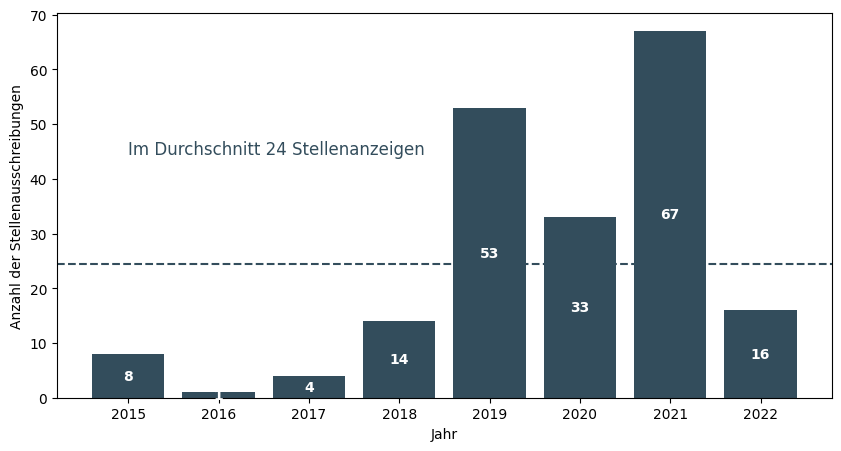

In [64]:
import matplotlib.pyplot as plt

# Set color
color = '#334d5c'

# Sort the data by years
sorted_data = sorted(number_of_ads_per_year.items())

# Creating a figure object
fig = plt.figure(figsize=(10,5))
fig, ax = plt.subplots(figsize=(10,5))

# Creating bar plot with job data
years = [x[0] for x in sorted_data]
counts = [x[1] for x in sorted_data]
bars = ax.bar(years, counts, color=color)

# Set lable for number of postings
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height/2, int(height),
            ha='center', va='center', color='white', fontweight='bold', fontsize=10)

# Set axis, labels and title
ax.set_xlabel('Jahr', fontsize=10)
ax.set_ylabel('Anzahl der Stellenausschreibungen', fontsize=10)
#plt.title("Number of job postings by year", fontsize=16)

# Calculate the average
mean = sum(counts) / len(counts)
line = plt.axhline(y=mean, xmin=0, xmax=1, ls='--', color=color)
mean_text = 'Im Durchschnitt 'f"{mean:.0f} Stellenanzeigen"
plt.text (2015, mean+20, mean_text,fontsize=12,color=color, rotation='horizontal')
# Display chart
plt.show()

3.4 General Preprossesing
*   Tokenize documents
*   Remove numbers, but not words that contain numbers
*   Remove stopwords
*   Lemmatization


In [65]:
!pip install spacy --quiet
nltk.download('omw-1.4');
nltk.download('wordnet');
nltk.download('punkt');
import spacy
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from matplotlib import pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

# Create list whith all documents for tasks like computing bigrams/trigrams
docs_all = []
filtered_docs_all = []
docs_by_year = {}
docs_by_year_corpus = {}
new_doc_complete_all = []
filtered_docs_all_corpus = []

# Preprossesing based on year
for year in year_dfs:

  docs = list(year_dfs[year]['descriptionTokenized'])

  # Tokenize the documents
  tokenizer = RegexpTokenizer(r'[\w#+]+')
  for idx in range(len(docs)):
      docs[idx] = docs[idx].lower()  # Convert to lowercase
      docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words

  # Remove numbers, but not words that contain numbers
  docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

  # Remove words that are only one character
  #docs = [[token for token in doc if len(token) > 1] for doc in docs]

  # Innizialise lemmatizer
  lemmatizer = WordNetLemmatizer()

  # Lemmatize the documents
  docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

  # Remove stopwords
  docs = [remove_stopwords(doc) for doc in docs]

  # Remove tokens that only contain numbers
  docs = [remove_numeric_tokens(doc) for doc in docs]

  # Add processed docs to docs_by_year dict
  docs_by_year[year] = docs

  # Add processed docs to docs_all list (used for overall lda model and bigram/trigram calculation)
  docs_all += docs

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


3.5 Compute bigrams, trigrams with gensim phraser

In [66]:
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser

# Compute bigrams
bigram = Phrases(docs_all, min_count=10)#, threshold=6)
# Compute trigrams
trigram = Phrases(docs_all, min_count=10)

3.6 Define phrases to be ignored and function to revert unwanted phrases

In [67]:
# Define word pairs to be ignored within the phrases creation
ignored_phrases = ['german_english', 'example_sentence', 'bachelor_master', 'verbal_written', 'written_spoken', 'english_german', 'spoken_written',
'written_verbal', 'oral_written', 'word_excel', 'fluency_english', 'dutch_french', 'python_r', 'excel_powerpoint', 'economics_mathematics',
'end_end', 'french_dutch', 'advanced_excel', 'lean_six', 'excel_word', 'powerpoint_excel', 'javascript_html', 'mathematics_comparable',
'mathematics_statitic', 'html5_cs']

# Revert unwanted phrases back into individual words in the document
def revert_unwanted_phrases(doc, ignored_phrases):
  for phrase in doc:
    if '_' in phrase and phrase in ignored_phrases:
        word1, word2 = phrase.split('_')
        index = doc.index(phrase)  # Index of the original trigram
        doc.remove(phrase)  # Remove the original trigram
        doc.insert(index, word1)  # Insert the first word at the original position
        doc.insert(index + 1, word2)  # Insert the second word right after
  return doc

3.7 Preprocessing tokens

There are three options for token filterung:
*   Option #1: Keep only tokens that are included in the skills list
*   Option #2: Use all words, except stopwords (default)
*   Option #3: POS-Tragging (Keep only Nouns, Verbs & Adjectives)
*   Creating bigrams/trigrams
*   replace synonym skills



In [68]:
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser

# Preprossesing based on year
for year in docs_by_year:

  # Load docs for year
  docs = docs_by_year[year]

  # Creating bigrams/trigrams, filter out phrases that should be ignored
  for idx in range(len(docs)):
      # Creating bigrams/trigrams calculated by gensim phraser
      docs[idx] = trigram[bigram[docs[idx]]]
      # Filter out phrases that should be ignored
      docs[idx] = revert_unwanted_phrases(docs[idx], ignored_phrases)

  # Store filtered docs
  filtered_docs = []
  # Filter docs (Only necessary if using the 'skills' list)
  for doc in docs:
      # Define tokens
      tokens = doc

      # OPTION #1: Keep only tokens that are included in the skills list
      if filter_by_skills:
        new_tokens = [token for token in tokens if token in skills]

      # OPTION #2: Use all words, except stopwords (default)
      new_tokens = [token for token in tokens if token not in custom_stop_words]

      # OPTION #3 POS-Tragging (Keep only Nouns, Verbs & Adjectives)
      #new_tokens = filter_pos_tags(new_tokens)

      # Convert list of tokens into a string and add it to the new list of documents
      filtered_docs.append(new_tokens)

  # Replace synonym skills
  replace_synonym_skills(filtered_docs, skill_synonyms)

  # Store filtered docs by year
  docs_by_year[year] = filtered_docs

  # Store filtered docs for the entire period
  filtered_docs_all += filtered_docs

3.8 Visualiz number of tokens per document

<Figure size 1000x500 with 0 Axes>

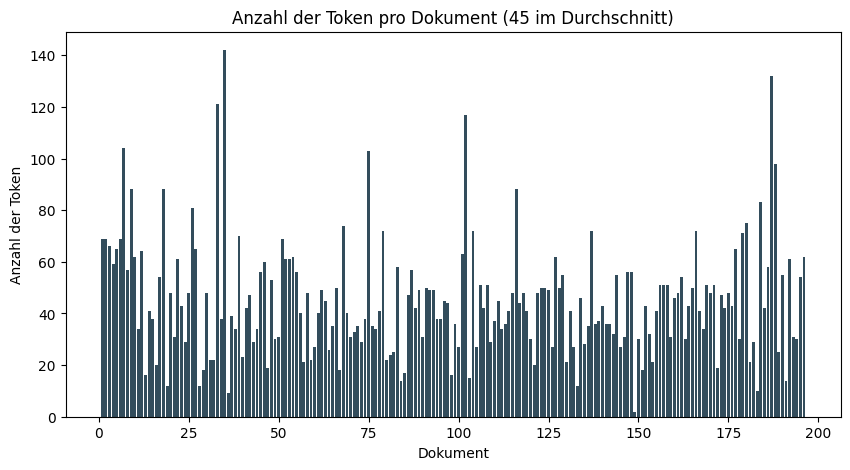

In [69]:
import matplotlib.pyplot as plt

# Create a figure with a specific size
fig = plt.figure(figsize=(10, 5))

# Create subplots within the figure with a specific size
fig, ax = plt.subplots(figsize=(10, 5))

# Determine the number of tokens per document
token_counts = [len(doc) for doc in filtered_docs_all]

# Create an index for the x-axis
x = range(1, len(filtered_docs_all) + 1)

# Calculate the token mean
mean = sum(token_counts) / len(token_counts)

# Create the chart and define labels
plt.bar(x, token_counts,color=color)
plt.xlabel('Dokument')
plt.ylabel('Anzahl der Token')
plt.title('Anzahl der Token pro Dokument (' + f"{mean:.0f} im Durchschnitt)")
plt.show()

# 4. Static Topic Modeling (LDA model)


*   Setting model parameter
*   Train static LDA model (all data)
*   Calculate probability of topics per year
*   Extract token frequencies (all data)
*   Train LDA model (by year)
*   Extract token frequencies (by year)
*   Export topic visualisation (all data, by year)

4.1 Setting model parameter

In [70]:
import numpy as np
# Set training parameters
num_topics = 15 # Specifies the number of topics to be extracted from the corpus
chunksize = 5000 # Sets the number of documents used in each chunk during training to avoid memory issues
passes = 20 # Sets the number of training passes to improve the model accuracy
iterations = 400 # Sets the maximum number of iterations during the inference process for each document, which determines the accuracy of the model

# Number of keywords per topic to display
num_keywords = 20

# Setting the seed to ensure the reproducibility of the results
seed = 22
np.random.seed(seed)

# Calculation of coherence for evaluation (disabled by default)
calculate_coherence = False

4.2 Train static LDA model (all data)


*   used gensim for lda topic modeling, bag of words and tfidf can be selected


In [71]:
!pip install gensim --quiet
from gensim.models import LdaModel
from gensim import corpora, models
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

# Create dictionary representation of the documents
dictionary = Dictionary(filtered_docs_all)

# Remove words that appear in fewer than 10 documents or in more than 80% of the documents (deactivated by default)
#dictionary.filter_extremes(no_below=10, no_above=0.8)

# Option #1: Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in filtered_docs_all]

# Option #2: TF-IDF representation of the documents (deactivated by default)
#tfidf = TfidfModel(corpus)
#corpus = tfidf[corpus]

# Make an index to word dictionary
temp = dictionary[0]  # Used only to "load" the dictionary
id2word = dictionary.id2token

# Lda model
model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    random_state=seed
)

# Calculation of Coherence
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=model, texts=filtered_docs_all,dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence (c_v):', coherence_lda)

# Calculation of Perplexity
perplexity_lda = model.log_perplexity(corpus)
print('Perplexity:', perplexity_lda)

Coherence (c_v): 0.464437553622402
Perplexity: -6.987446284500592


4.3 Display topics and topic keywords

In [72]:
import pandas as pd
from IPython.display import display, HTML

# Extract the top keywords for each topic
topics = model.show_topics(num_topics=num_topics, num_words=num_keywords, formatted=False)

# Create a table with the topics and keywords
table_data = []
for topic_id, topic_words in topics:
    keywords = [word for word, _ in topic_words]
    table_data.append([f"Topic {topic_id}", ", ".join(keywords)])

# Sort the table by topic index
table_data.sort(key=lambda x: int(x[0].split()[1]))

# Create the dataframe
df = pd.DataFrame(table_data, columns=["Topic", "Keywords"])

# Set the width of the "Keywords" column
pd.set_option("display.max_colwidth", 250)

# Display table
display(df)

# Print topics with probabilities
#for idx, topic in model.print_topics(-1):
    #print(f'Topic: {idx} \nWords: {topic}\n')

,Topic,Keywords
0,Topic 0,"degree, english_language, german_language, modeling, project, economics, project_management, initiative, university, professional_experience, signavio, comprehensive, hand, method, thinking, completed, standard, area, similar, engineering"
1,Topic 1,"english_language, pronounced, structured, oriented, study, project, communication, degree, business_process_management, professional_experience, way_working, sap, comparable, course, handling, organizational, solution, focus, advantage, design"
2,Topic 2,"logistics, supply_chain, degree, professional_experience, del, sap, quantitative, proactively, embrace, qualification, team_player, change, love, earned, act, collaboration, lean, focus, project, english_language"
3,Topic 3,"dutch, interest, french, master_degree, technology, born, analytical, fluent_english, engineering, automation, thinking, end, natural, equivalent, basic, affinity, critical, mind, preferred, science"
4,Topic 4,"office, german_language, business_informatics, study, especially, sale, english_language, industrial_engineering, team, competence, technique, comparable, driving, international, strength, standard, desirable, service, initiative, professional_ex..."
5,Topic 5,"process_mining, area, english_language, business_informatics, communication_skill, computer_science, able, big_data, technology, data, similar, comparable, mathematics, business_administration, economics, study, mining, various_customer, improvem..."
6,Topic 6,"data, project, customer, operational, stakeholder, excellence, technology, sql, meaningful, insight, translate, based, basic, similar, change, professional_experience, python, english_language, communication_skill, team"
7,Topic 7,"software, team, written, technical, english_language, demonstrated, engineering, communication_skill, development, verbal, advanced, analytical_skill, computer_science, degree, service, functional, communication, technology, lifecycle, industry"
8,Topic 8,"automation, computer_science, english_language, c, study, tool, programming_language, economics, comparable, analysis, modeling, communication_skill, german_language, python, anywhere, practical_experience, methodology, java, ++, blue"
9,Topic 9,"project, office, team, microsoft, environment, project_management, communication_skill, organization, bank, operation, suite, microsoft_excel, written, quality, english_language, analytical, professional, able, problem_solving, oral"


4.4 Export topic visualisation with pyldavis (all data)

In [73]:
# Visualization of topics
visualization_with_vis(model, corpus, dictionary,'overall')

4.5 Calculate token frequencies (token counted only once per doc, all data)

In [74]:
# Extract the frequency of each token from the corpus
token_frequencies = {}
for doc in corpus:
    tokens_in_doc = set()
    for token_id, freq in doc:
        token = dictionary[token_id]
        if token not in tokens_in_doc:
            tokens_in_doc.add(token)
            if token in token_frequencies:
                token_frequencies[token] += 1
            else:
                token_frequencies[token] = 1

# Sort the tokens by descending frequency
sorted_tokens = sorted(token_frequencies.items(), key=lambda x: x[1], reverse=True)

4.6 Store lda models & token frequencies

In [75]:
# Store lda model, token frequencies for each year
lda_models = {}
token_freqs = {}
lda_model_overall = []
token_freqs_overall = []
token_freqs_overall_dict = {}

# Add model to lda_model list
lda_model_overall = model
token_freqs_overall = sorted_tokens
token_freqs_overall_dict = {tup[0]: tup[1] for tup in sorted_tokens}

4.7 Calculate the probabilities of topics over years and visualize them



*   Calculate probabilities




In [76]:
# List of years
years = docs_by_year.keys()

# Save topic distribution for each year
topic_distributions = {}

# Extract topic distribution for each year
for year in years:
    documents = docs_by_year[year]  # List of documents for the current year

    # Convert documents to BoW format for the LDA model
    year_corpus = [dictionary.doc2bow(document) for document in documents]

    # Extract topic distribution for each document of the current year
    topic_distribution_year = []
    for document in year_corpus:
        topic_probs = np.zeros(model.num_topics)
        topic_distribution = model.get_document_topics(document)
        for topic, prob in topic_distribution:
            topic_probs[topic] = prob
        topic_distribution_year.append(topic_probs)

    topic_distributions[year] = topic_distribution_year

# Create an array to store influence scores for each year and topic
influence_scores = np.zeros((len(years), model.num_topics))
for i, year in enumerate(years):
    for topic in range(model.num_topics):
        topic_probs = np.array(topic_distributions[year])[:, topic]
        influence_scores[i, topic] = np.mean(topic_probs)

*   Visualize the topic probabilities over the years
  *   Each subplot represents a topic and contains a line plot showing the probability scores of the topic over the years



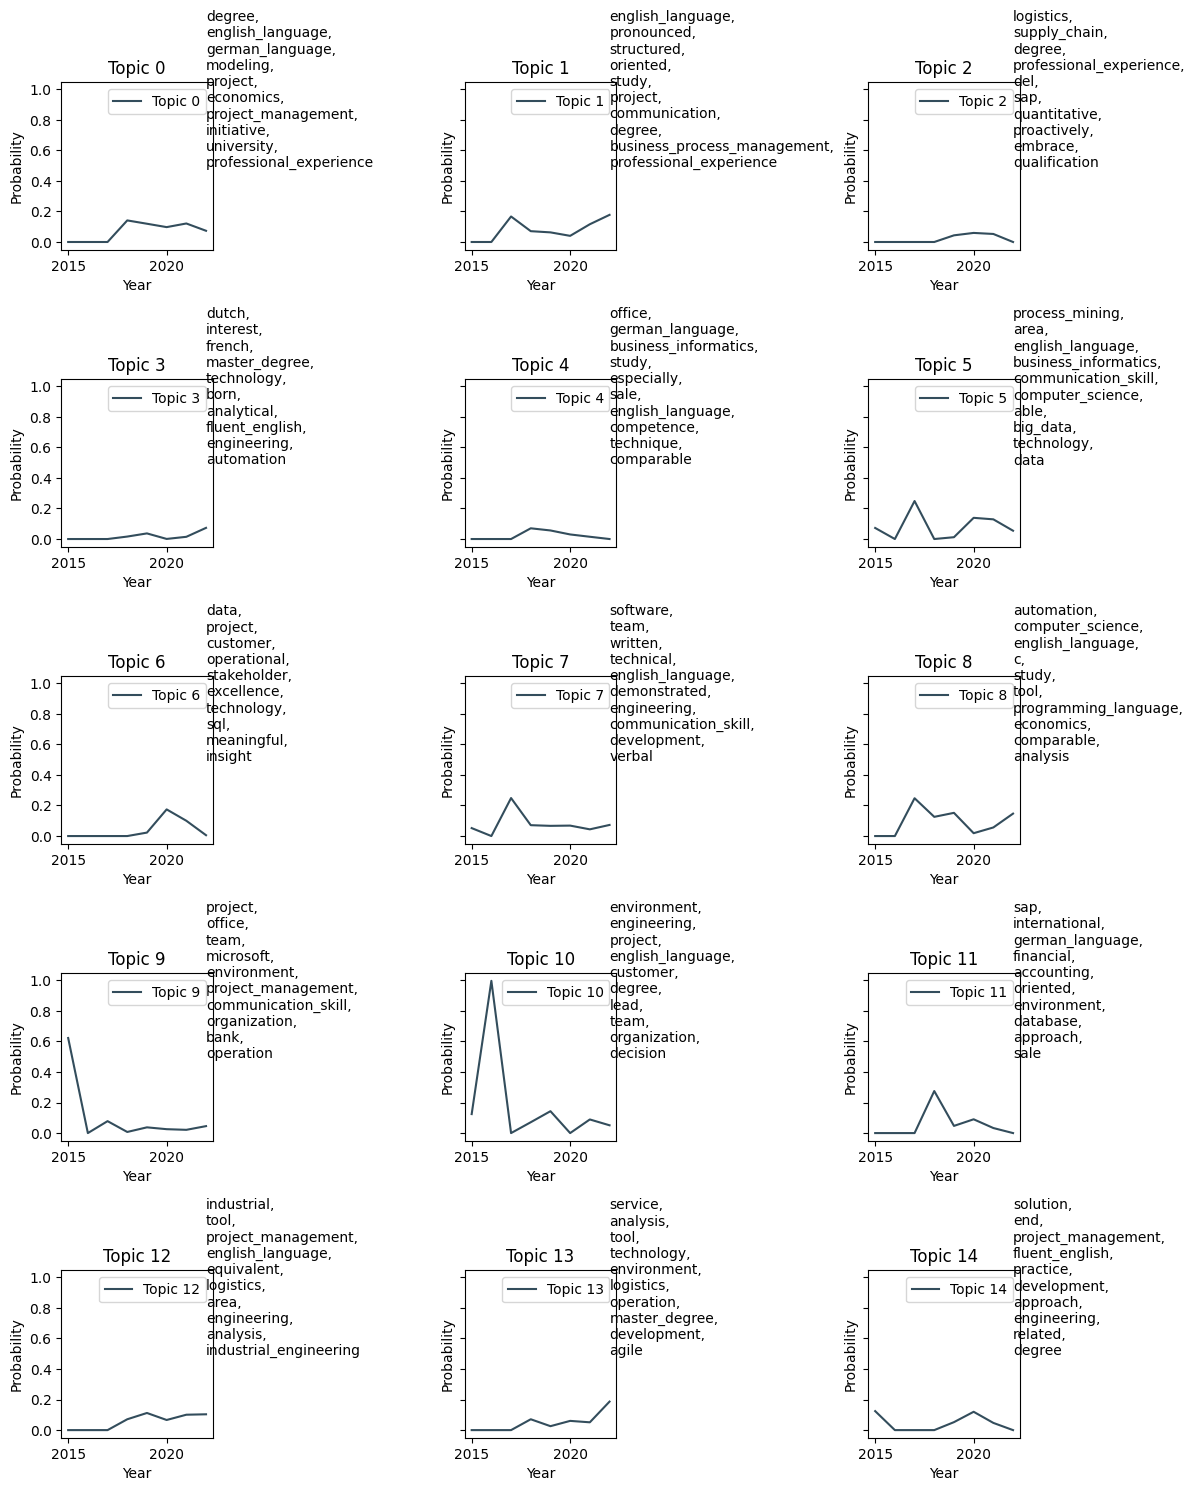

In [77]:
# Determine the number of rows and columns for the subplots
num_rows = int(np.ceil(model.num_topics / 3))  # Number of rows
num_cols = min(3, model.num_topics)  # Number of columns (maximum 3)

# Set the size of the overall plot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3*num_rows), sharey=True)

# Plot bar charts for each topic
for topic in range(model.num_topics):
    ax = axes[topic // num_cols, topic % num_cols]  # Select current axis

    # Plot lines for each year
    ax.plot(years, influence_scores[:, topic], label=f"Topic {topic}", color=color)


    # Extract the top 10 words of the topic
    top_word_ids = [word_id for word_id, _ in model.get_topic_terms(topic, topn=10)]
    top_words = [dictionary[word_id] for word_id in top_word_ids]
    top_words_str = ', '.join(top_words)

    ax.set_xlabel("Year")
    ax.set_ylabel("Probability")
    ax.set_title(f"Topic {topic}")
    ax.legend()

    # Add the top 10 words of the topic as text (only once for the topic)
    ax.text(list(years)[-1], np.max(influence_scores), '\n'.join(top_words_str.split()), ha='left', va='center')

# Remove extra axes if the number of topics is not divisible by 3
if model.num_topics % 3 != 0:
    for i in range(model.num_topics, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

4.8 Train static LDA model & export token frequencies (by year)

In [78]:
import warnings
from gensim.models import LdaModel
from gensim.models.phrases import Phrases

# Ignore warning caused by gensim library, improve readability
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Analysis based on year
for year in docs_by_year:

  # User info
  print('Analysing job advertisement data of ' + str(year) + ' (' + str(len(docs_by_year[year])) + ')...')

  docs = docs_by_year[year]

  # Create a dictionary representation of the documents
  dictionary = Dictionary(filtered_docs_all)

  # Remove words that appear in fewer than 10 documents or in more than 80% of the documents (deactivated by default)
  #dictionary.filter_extremes(no_below=10, no_above=0.8)

  # Bag-of-words representation of the documents
  corpus = [dictionary.doc2bow(doc) for doc in docs]


  # Make an index to word dictionary.
  temp = dictionary[0]  # Used only to "load" the dictionary
  id2word = dictionary.id2token

  # Train lda model
  lda_model = LdaModel(
      corpus=corpus,
      id2word=id2word,
      chunksize=chunksize,
      alpha='auto',
      eta='auto',
      iterations=iterations,
      num_topics=num_topics,
      passes=passes
  )

  # Print topics
  for idx, topic in model.print_topics(-1):
      print(f'Topic: {idx} \nWords: {topic}\n')


  # Extract the frequency of each token from the corpus (only counted once per doc)
  token_frequencies = {}
  for doc in corpus:
      tokens_in_doc = []
      tokens_in_doc = set()
      for token_id, freq in doc:
          token = dictionary[token_id]
          if token not in tokens_in_doc:
              tokens_in_doc.add(token)
              if token in token_frequencies:
                  token_frequencies[token] += 1
              else:
                  token_frequencies[token] = 1


  # Sort the tokens by descending frequency
  sorted_tokens = []
  sorted_tokens = sorted(token_frequencies.items(), key=lambda x: x[1], reverse=True)

  # Add model to lda_model list
  lda_models[year] = lda_model
  token_freqs[year] = sorted_tokens

  # Topic Visualisation
  visualization_with_vis(lda_model, corpus, dictionary, str(year))

Analysing job advertisement data of 2015 (8)...
Topic: 0 
Words: 0.028*"degree" + 0.023*"english_language" + 0.021*"german_language" + 0.014*"modeling" + 0.013*"project" + 0.013*"economics" + 0.011*"project_management" + 0.011*"initiative" + 0.010*"university" + 0.010*"professional_experience"

Topic: 1 
Words: 0.018*"english_language" + 0.016*"pronounced" + 0.015*"structured" + 0.014*"oriented" + 0.013*"study" + 0.013*"project" + 0.012*"communication" + 0.011*"degree" + 0.011*"business_process_management" + 0.010*"professional_experience"

Topic: 2 
Words: 0.018*"logistics" + 0.018*"supply_chain" + 0.016*"degree" + 0.013*"professional_experience" + 0.011*"del" + 0.011*"sap" + 0.011*"quantitative" + 0.011*"proactively" + 0.011*"embrace" + 0.011*"qualification"

Topic: 3 
Words: 0.025*"dutch" + 0.021*"interest" + 0.020*"french" + 0.019*"master_degree" + 0.015*"technology" + 0.013*"born" + 0.011*"analytical" + 0.010*"fluent_english" + 0.010*"engineering" + 0.009*"automation"

Topic: 4 
W

4.9 Print most important tokens per year

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create dictionary to store skill importance per year
skills_importance = {}

# Loop over each year and calculate token importance
for year in docs_by_year:
    skills = []
    for doc in docs_by_year[year]:
        skills.extend(doc)
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_scores = tfidf_vectorizer.fit_transform(skills)
    importance = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_scores.sum(axis=0).A1))
    skills_importance[year] = importance

# Output the top 10 tokens per year
for year, skills in skills_importance.items():
    sorted_skills = sorted(skills.items(), key=lambda x: x[1], reverse=True)[:20]
    print(f"Jahr {year}:")
    for skill, importance in sorted_skills:
        print(f"- {skill}: {importance}")

Jahr 2015:
- office: 10.0
- project: 10.0
- environment: 8.0
- microsoft: 8.0
- team: 8.0
- microsoft_excel: 7.0
- project_management: 7.0
- written: 7.0
- bank: 6.0
- communication_skill: 6.0
- organization: 6.0
- analytical: 5.0
- manage: 5.0
- multiple: 5.0
- operation: 5.0
- problem_solving: 5.0
- risk: 5.0
- word: 5.0
- back: 4.0
- contact: 4.0
Jahr 2016:
- environment: 3.0
- manage: 2.0
- preferred: 2.0
- adapt: 1.0
- advanced: 1.0
- analytical_skill: 1.0
- assignment: 1.0
- bachelor_degree: 1.0
- balance: 1.0
- based: 1.0
- certification: 1.0
- changing: 1.0
- code: 1.0
- communicate: 1.0
- concern: 1.0
- concurrent: 1.0
- constantly: 1.0
- contribute: 1.0
- critical: 1.0
- cultural: 1.0
Jahr 2017:
- team: 4.0
- communication_skill: 3.0
- environment: 3.0
- able: 2.0
- communicate: 2.0
- digital: 2.0
- fluent_english: 2.0
- improvement: 2.0
- internal: 2.0
- microsoft_excel: 2.0
- scale: 2.0
- study: 2.0
- task: 2.0
- technology: 2.0
- tool: 2.0
- written: 2.0
- accounting: 1.0


4.10 Visualization of static LDA topic modeling

*   Prepare data for plotting



In [80]:
# Create list to store all extracted skills
most_mentioned_skills = []
for token, freq in token_freqs_overall:
  most_mentioned_skills.append(token)

# Create dict to store the calculated value by year (in which percentage of advertisements is the skill required)
most_mentioned_skills_per_year = {}

# Calculate percentage for each skill in each year
for skill in most_mentioned_skills:
  for year in token_freqs:
    value = 0
    for term, count in token_freqs[year]:
      if skill == term:
        value = count/number_of_ads_per_year[year]
        break
    if skill in most_mentioned_skills_per_year:
      most_mentioned_skills_per_year[skill].append(value)
    else:
      most_mentioned_skills_per_year[skill] = []
      most_mentioned_skills_per_year[skill].append(value)

print(most_mentioned_skills_per_year)

{'english_language': [0.375, 0, 0.25, 0.5, 0.6792452830188679, 0.6060606060606061, 0.6567164179104478, 0.625], 'german_language': [0, 0, 0, 0.5, 0.5283018867924528, 0.36363636363636365, 0.40298507462686567, 0.375], 'communication_skill': [0.75, 0, 0.75, 0.5, 0.32075471698113206, 0.3939393939393939, 0.29850746268656714, 0.375], 'project': [0.875, 1.0, 0, 0.2857142857142857, 0.32075471698113206, 0.24242424242424243, 0.40298507462686567, 0.25], 'degree': [0.125, 1.0, 0, 0.42857142857142855, 0.2830188679245283, 0.21212121212121213, 0.34328358208955223, 0.375], 'computer_science': [0, 0, 0.25, 0.35714285714285715, 0.2830188679245283, 0.24242424242424243, 0.26865671641791045, 0.5], 'area': [0.125, 0, 0, 0.21428571428571427, 0.32075471698113206, 0.30303030303030304, 0.22388059701492538, 0.0625], 'comparable': [0, 0, 0.25, 0.14285714285714285, 0.2641509433962264, 0.24242424242424243, 0.2835820895522388, 0.1875], 'team': [0.75, 0, 0.5, 0.21428571428571427, 0.3018867924528302, 0.1818181818181818

*   Visualisation the development of tokens over time (Skill Count)

  *   shows the percentage of documents per year in which a token appears

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from matplotlib.ticker import FormatStrFormatter

# X-axis
years = np.array(list(token_freqs.keys()))

# Create a checkbox list for skills
skills_list = list(most_mentioned_skills_per_year.keys())
skills_checkboxes = widgets.SelectMultiple(
    options=skills_list,
    value=[skills_list[0]],  # Default value for initial selection
    rows=10,
    description='Skills:',
    disabled=False,
    layout=widgets.Layout(height='200px')
)

# Create a function to plot the selected skills
def plot_skills(skills):
    plt.clf() # clear the old plot

    fig = plt.figure(figsize=(10,5))
    fig, ax = plt.subplots(figsize=(10,5))
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))

    for skill in skills:
        skill_data = np.array(most_mentioned_skills_per_year[skill])
        plt.plot(years, skill_data, label=skill)

        # Add the percentage as a label for each data point
        for i, data_point in enumerate(skill_data):
            plt.text(years[i], data_point, f"{data_point:.1%}", ha='center', va='bottom', fontsize=10)

    # Set the x-axis ticks to correspond to the year values
    ax.set_xticks(years)

    # Label the axes
    plt.xlabel("Year")
    plt.ylabel("Number of job advertisements")

    # Add title
    plt.title("Development of skill requirements over time", fontsize=16)

    # Add legend and show plot
    plt.legend()
    plt.show()

# Link the checkbox list to the plot function
widgets.interactive(plot_skills, skills=skills_checkboxes)

interactive(children=(SelectMultiple(description='Skills:', index=(0,), layout=Layout(height='200px'), options…

# 5. Dynamic Topic Modeling (LDA)

Implemented with lda_over_time framework. Two differnet LDA models can be used:


1.   Temporal LDA Model

*   inferior results but significantly lower runtime


2.   LDA Seq Model (used by default)


  *   better results but significantly higher runtime

5.1 Set number of topics




In [82]:
n_topics = 12

5.2 Generate timestamp for each document and convert documents

In [83]:
import pandas as pd

timestamps_by_year = []

# Generates year-based timestamps for all documents
for year, docs in docs_by_year.items():
    start_date = pd.Timestamp(year, 1, 1)
    end_date = pd.Timestamp(year+1, 1, 1)

    timestamps = []
    for doc in docs:
        timestamp = pd.Timestamp(year=year, month=1, day=1)
        timestamps.append(str(year))
    timestamps_by_year += (timestamps)

# Converts words in lists into a single string, needed for topic over time model
docs = [" ".join(doc) for doc in filtered_docs_all]

5.3 Install lda-over-time

In [84]:
!pip install lda-over-time --quiet

5.4 Setting up Temporal LDA Model

In [85]:
from lda_over_time.lda_over_time import LdaOverTime
from lda_over_time.models.temporal_lda_model import TemporalLdaModel

temporal_lda_model = TemporalLdaModel(
    corpus = docs,         # list texts to be analysed
    dates = timestamps_by_year,     # dates of each article
    date_format = "%Y",        # date format is MM/DD/YYYY
    freq = "12M",                     # frequency of one semester
    n_topics = n_topics,                    # we want to get 5 topics
    aggregator = "average"           # calculate average of topics
)

5.5 Setting up LDA Seq Model (used by default)

In [86]:
from lda_over_time.lda_over_time import LdaOverTime
from lda_over_time.models.lda_seq_model import LdaSeqModel


lda_seq_model = LdaSeqModel(
    corpus = docs,         # list texts to be analysed
    dates = timestamps_by_year,     # dates of each article
    date_format = "%Y",        # date format is MM/DD/YYYY
    freq = "12M",                     # frequency of one semester
    n_topics = n_topics,                    # we want to get 5 topics
)

5.6 Train the dynamic LDA model

In [ ]:
# Train LDA Over Time model
main = LdaOverTime(lda_seq_model)

# Print topic keywords for each topic
for i in range(n_topics):
  print(main.get_topic_words(topic_id=i, timeslice=8, n=20))

5.7 Visualization of topic probability over years

In [ ]:
# Visualisation of the topics and their development over the years
main.plot(

    # Plot's title
    title = 'Topics',

    # Legend's title
    legend_title="Topics",

    # Set location to save
    # path_to_save="./plot_of_news.png",

    # Display graph (default)
    display=True,

    # Rotate labels in 75º
    rotation=75,

    # Plot lines (default)
    mode="line",

    # Set custom date format to YYYY
    date_format="%Y"
)

5.8 Visualisation of the topics and their development over the years (filter by topic)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Saving the topic probability
topic_probability = main.get_results()
topic_probability.set_index('date', inplace=True)

# Create a list of topic numbers for the checkboxes
topics = topic_probability.columns.tolist()

# Create a checkbox list for the topics
topics_checkboxes = widgets.SelectMultiple(
    options=topics,
    value=[topics[0]],  # Default value for the output selection
    description='Topics:',
    disabled=False,
    layout=widgets.Layout(height='150px')
)

# Create plot function
def plot_topics(topics):
    plt.clf()  # delete current plot

    fig, ax = plt.subplots(figsize=(10, 5))

    # Create line for each selected topic
    for topic in topics:
        plt.plot(topic_probability.index.year, topic_probability[topic], label=f'Topic {topic}')

    # Label axes
    plt.xlabel("Year")
    plt.ylabel("Probability")

    # Add title
    plt.title("Topic Probabilities Over Time", fontsize=16)
    plt.text
    plt.text(3, 35, main.get_topic_words(topic_id=topic, timeslice=1, n=5), fontsize=12, ha='center')

    # Add legend
    plt.legend()
    plt.show()

# Link checkbox list with plot function
widgets.interactive(plot_topics, topics=topics_checkboxes)

# 6. Evaluation

6.1 Evaluation of static LDA model for different number of topics

In [ ]:
if calculate_coherence:
  from gensim.test.utils import common_corpus, common_dictionary
  from gensim.models.ldamodel import LdaModel
  from gensim.models.coherencemodel import CoherenceModel

  # Lists for storing coherence
  coherence_values = []
  coherence_values_cv = []
  coherence = []

  for num_topics in range(1, 50, 1):

      # List of years
      years = docs_by_year.keys()

      # Save topic distribution for each year
      topic_distributions = {}

      # Combine all documents into a single corpus
      combined_documents = [document for year in years for document in docs_by_year[year]]

      # Convert documents to BoW format for the LDA model
      dictionary = corpora.Dictionary(combined_documents)

      # Remove words that appear in fewer than 10 documents or in more than 80% of the documents (deactivated by default)
      #dictionary.filter_extremes(no_below=10, no_above=0.8)

      # Define the corpus
      corpus = [dictionary.doc2bow(document) for document in combined_documents]

      # Train the LDA model on the entire corpus
      lda_model = LdaModel(
          corpus=corpus,
          id2word=dictionary,
          chunksize=chunksize,
          alpha='auto',
          eta='auto',
          iterations=iterations,
          num_topics=num_topics,
          passes=passes,
          random_state=seed
      )

      # Calculation of coherence with the c_v coherence model
      coherence_model_cv = CoherenceModel(model=lda_model, texts=combined_documents, dictionary=dictionary, coherence='c_v')
      coherence_cv = coherence_model_cv.get_coherence()
      coherence_values_cv.append(coherence_model_cv.get_coherence())
      #print(("Number of Topics: " + str(num_topics) + " -> Coherence (c_v): " + str(coherence_cv)))

      # Calculation of coherence with the u_mass coherence model
      coherence_model_u_mass = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
      coherence_values.append(("Number of Topics: " + str(num_topics) + " -> Coherence: " + str(coherence_model_u_mass.get_coherence())))
      coherence.append(coherence_model_u_mass.get_coherence())
      #print(("Number of Topics: " + str(num_topics) + " -> Coherence (u_mass): " + str(coherence_model_u_mass.get_coherence())))

6.2 Coherence score (c_v)

In [ ]:
if calculate_coherence:
  import matplotlib.pyplot as plt

  # Set parameters
  limit = 50
  start = 1
  step = 1
  x = range(start, limit, step)

  # Set color
  color = '#334d5c'

  fig = plt.figure(figsize=(10,5))
  fig, ax = plt.subplots(figsize=(10,5))

  # Find the lowest coherence value
  max_coherence = max(coherence_values_cv)

  # Find the index of the lowest y-value
  index_min_y = np.argmax(coherence_values_cv)

  # Access the corresponding x-value with the found index
  x_min_y = x[index_min_y]

  # Plot the coherence line and line for the lowest value
  plt.plot(x, coherence_values_cv, color=color, label='Kohärenz (c_v)')
  plt.axvline(x=x_min_y, color=color, linestyle='--')

  # Add text for best coherence value
  #best_coherence_text = "Best coherence score \nfor " + f"{x_min_y:.0f} topics (" + f"{max_coherence:.2f})"
  #plt.text(x_min_y + 1, 0.34, best_coherence_text, fontsize=12, color=color, rotation='horizontal')

  # Add ticks at full numbers on x-axis
  ax.set_xticks(np.arange(start, limit, 2))

  # Add labels and show plot
  plt.xlabel("Anzahl der Topics")
  plt.ylabel("Kohärenz-Score")
  #plt.title("Kohärenz-Score (c_v) für unterschiedliche Anzahl an Topics", fontsize=16)
  plt.legend()
  plt.show()

6.3 Coherence score (u_mass)

In [ ]:
if calculate_coherence:
  import matplotlib.pyplot as plt

  # Set parameters
  limit = 50
  start = 1
  step = 1
  x = range(start, limit, step)

  # Set color
  color = '#334d5c'

  fig = plt.figure(figsize=(10,5))
  fig, ax = plt.subplots(figsize=(10,5))

  # Find the lowest coherence value
  min_coherence = min(coherence)

  # Find the index of the lowest y-value
  index_min_y = np.argmin(coherence)

  # Access the corresponding x-value with the found index
  x_min_y = x[index_min_y]

  # Plot the coherence line and line for the lowest value
  plt.plot(x, coherence, color=color, label='Kohärenz (u_mass)')
  #plt.axvline(x=x_min_y, color=color, linestyle='--')

  # Add text for best coherence value
  #best_coherence_text = "Best coherence score \nfor " + f"{x_min_y:.0f} topics (" + f"{min_coherence:.2f})"
  #plt.text(x_min_y + 2, -6, best_coherence_text, fontsize=12, color=color, rotation='horizontal')

  # Add ticks at full numbers on x-axis
  ax.set_xticks(np.arange(start, limit, 2))

  # Add labels and show plot
  plt.xlabel("Anzahl der Topics")
  plt.ylabel("Kohärenz-Score")
  #plt.title("Kohärenz-Score (u_mass) für unterschiedliche Anzahl an Topics", fontsize=16)
  plt.legend()
  plt.show()